In [49]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as optimize 
import scipy.fftpack as fftpack
import scipy.signal as signal 
import scipy.interpolate as interpolate
import types
import algopy
import lmfit
# Magic
import mpmath as mp

mp.mp.dps = 22
mp.mp.pretty=True
print(mp.mp)

pylab.rcParams['figure.figsize'] = (15.0, 3.0)
pylab.rcParams['axes.facecolor'] = 'lightgray'

Mpmath settings:
  mp.prec = 76                [default: 53]
  mp.dps = 22                 [default: 15]
  mp.trap_complex = False     [default: False]


In [50]:
# vmpsub = np.vectorize(mp.fsub)
vmpexp = np.vectorize(mp.exp)
vmpsqrt = np.vectorize(mp.sqrt)
vmpfabs = np.vectorize(mp.fabs)

def mpToNp(mparr):
    return np.asarray([np.float64(x) for x in mparr])

def mpMean(arr):
    sum = mp.mpf(0.0)
    for i in arr:
        sum += i
    return  sum / len(arr)

In [51]:
def gauss(x, mu, sigma, amplitude): 
    return amplitude * vmpexp( - ((x - np.asarray([mu])) ** 2) / (2 * (sigma**2) ))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = mp.mpf(0.0);
    for i in range(0, int((maxWl-minWl) / period)):
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
    return result

# x = mp.linspace(0, 10, 100)
# y = per_gauss(x, 0.1, 1, 9, 1, 100)
# plt.plot(x, y)
# print(lol)

In [52]:
class Spectrograph:
    def __init__(self, xres, bgrNoiseMu, bgrNoiseSD, minWl, maxWl, precision):
        self.xres = mp.mpf(xres)
        self.bgrNoiseMu = mp.mpf(bgrNoiseMu)
        self.bgrNoiseSD = mp.mpf(bgrNoiseSD)
        self.minWl = mp.mpf(minWl)
        self.maxWl = mp.mpf(maxWl)
        self.precision = mp.mpf(precision)
    def activate(self, lfc):
        x = np.asarray(mp.linspace(self.minWl, self.maxWl, self.xres))
        bgrNoise = np.random.normal(self.bgrNoiseMu, self.bgrNoiseSD, len(x)).astype(mp.mpf) # Background noise
        bgrNoise[bgrNoise < 0.0] = 0.0

        # Lfc
        lfcReading = lfc.simulate(x, lfc.sigma, lfc.minWl, lfc.maxWl, lfc.dWl, lfc.intensity) # LFC
        # Also add shot noise. Noise is proportional to the square root of the intensity
        tempReading = mpToNp(lfcReading)
        tempReading[tempReading == 0.00] = 0.001
        shotNoise = np.random.normal(0, np.sqrt(tempReading) * np.float64(self.precision), len(x))
        lfcReading += shotNoise

        # Overlap inputs by adding to y
        y = bgrNoise + lfcReading
        return np.asarray(mp.linspace(0, self.xres, self.xres)), y

class LFC:
    def __init__(self, intensity, fhwm, minWl, maxWl, dWl):
        self.intensity = mp.mpf(intensity)
        self.sigma = mp.mpf(fhwm) / (2 * vmpsqrt(2 * mp.log(2))) # sd = fhwm / 2sqrt(2ln2)
        self.minWl = mp.mpf(minWl)
        self.maxWl = mp.mpf(maxWl)
        self.span = self.maxWl - self.minWl
        self.dWl = mp.mpf(dWl)
    def getPeaks(self):
        peaks = np.empty(0)
        current = self.minWl;
        while(current < self.maxWl):
            peaks = np.append(peaks, current)
            current += self.dWl
        return peaks
    def simulate(self, wlSpace, sigma, minWl, maxWl, period, amplitude):
        y = per_gauss(wlSpace, sigma, minWl, maxWl, period, amplitude)
        return y

In [55]:
def get_peaks(shift, lfc, n):
    peaks = np.empty(0)
    current = shift
    for i in range(0, n):
        peaks = np.append(peaks, current)
        current += lfc.dWl
    return peaks
    
def pred_error(y, pred_y, solution, prediction):
    lse = mpMean(vmpfabs(y - pred_y))
    error = mp.fabs(solution - prediction) / solution * mp.mpf(3e8)
    return lse, error
    
def guess_min(x, y):
    x = mpToNp(x) 
    y = mpToNp(y)
    guess_x = x[y > 2000]
    guess_y = y[y > 2000]
    max_idx = signal.argrelextrema(guess_y, np.greater, order=10)
    guess_max_x = guess_x[max_idx]
    guess_max_y = guess_y[max_idx]
    guess_x = guess_max_x[0]
    guess_y = guess_max_y[0]
    return mp.mpf(guess_x)

def pix_to_wl(pix, sgraph):
    fac = sgraph.xres / (sgraph.maxWl - sgraph.minWl)
    return ((pix / fac) + sgraph.minWl)
    
def find_lfc_peaks(sgraph, lfc):
    fac = sgraph.xres / (sgraph.maxWl - sgraph.minWl)
    lfc_peaks = lfc.getPeaks()
    def per_gauss_fit(wl, shift):
        return per_gauss(wl, lfc.sigma * fac, shift, shift + ((len(peaks) - 1) * lfc.dWl * fac), lfc.dWl * fac, lfc.intensity)

    print('Activating lfc...')
    x, y = sgraph.activate(lfc)
    
    # Want to minimize err_func
    err_func = lambda shift: mpMean(vmpfabs(per_gauss_fit(x, shift) - y))
    # Hence, want to find roots of derivative
    der_err_func = lambda x: mp.diff(err_func, x)
    guess_x = guess_min(x, y)
    print('initial guess for shift is:', np.asarray([guess_x])) 
    
    print('Minimizing...')
    pred_shift = mp.findroot(der_err_func, guess_x, tol=1e-10)
    
    print('pred_shift is', pred_shift)
    solution = (lfc.minWl - sgraph.minWl) * fac
    print('solution is', solution)

    pred_y = per_gauss_fit(x, pred_shift)
    
    pred_shift_wl = pix_to_wl(pred_shift, sgraph)
    print('pred_shift_wl is', pred_shift_wl)
    print('solution_wl is', lfc.minWl)
    pred_peaks = get_peaks(pred_shift_wl, lfc, len(lfc_peaks))
    lse, error = pred_error(y, pred_y, lfc.minWl, pred_shift_wl)
    print('Least squares error is ' + str(lse))
    print('Error is: ' + str(error))
    
    print(lfc_peaks[0:3], lfc_peaks[-3:])
    print(pred_peaks[0:3], pred_peaks[-3:])
    
    plt.scatter(x, y)
    plt.plot(x, per_gauss_fit(x, pred_shift))
    for peak in pred_peaks:
        plt.axvline((peak - sgraph.minWl) * fac, color='green')
    for peak in peaks:
        plt.axvline((peak - sgraph.minWl) * fac, color='purple')
    plt.axvline(guess_x, color='turquoise')
    plt.xlim(np.float64(guess_x) - 20, np.float64(guess_x) + 75)
    plt.show()
    
    return x,y

In [56]:
%%time
rand = mp.mpf(np.random.random(1)[0])
# rand = 0.0
lfc = LFC(20000, 0.0075, 400 + rand, 410 + rand, 0.03)
peaks = lfc.getPeaks()
sgraph = Spectrograph(4000, 1000.0, 300.0, 399.0, 411.0, 1.0)
find_lfc_peaks(sgraph, lfc)

Activating lfc...
('initial guess for shift is:', array([579.1447861965490346847], dtype=object))
Minimizing...
('pred_shift is', -976.2063635109963557961)
('solution is', 578.7365993325903253582)


KeyboardInterrupt: 

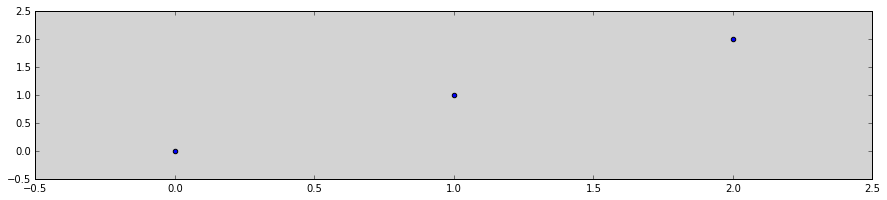

In [272]:
plt.scatter([0,1,2], [0,1,2])
fig = plt.figure()
# fig.show()

In [273]:
fig.xlim(0, 1)

AttributeError: 'Figure' object has no attribute 'xlim'